# Remote Timing Attacks are Practical
_Experiment 7: Measuring the effects of noise on attack efficacy._

---

In [1]:
import scipy
import scipy.signal
import seaborn
import sympy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [2]:
import tls
import attack
import utils

In [3]:
%matplotlib notebook
PLOT_KWARGS = {
    "height": 4.5, 
    "aspect": 16/8, 
}

In [4]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

## Theory

Questions: Is there too much noise in this setup to be feasible? Is this the reason for the poor results so far? Can these issues be overcome?

This section attempts to measure the noise and its impact on the attack (modelled after "Experiment 7" on the CompNet version of the paper[2]). Ideas from Crosby et al [4] are then used to provide an alternative approach to differentiating bits.

## Measuring Noise

Choose a non-zero constant value for our noise measurements:

In [5]:
g_bits = [1, 1, 0, 1] + [0] * 508
g = utils.bits_to_sympy_integer(g_bits)
len(g_bits), g

(512,
 10893843943078360143403895311042249978576984729231319619400393673023933274434756918651522867260609034998150884776519916318675029784706588081477339817443328)

Measure some throw away values to warm up the server.

In [5]:
_= attack.sample(
    [g],
    sample_size=10,
    neighbourhood_size=10,
    u_g=True,
    N=N,
)

First, try a sample size of 7 with no neighbours (a neighbourhood of 1) as in Table 2 Panel A in [2].

In [6]:
all_samples = []

for i in range(16):
    raw_samples = attack.sample(
        [g],
        sample_size=7,
        neighbourhood_size=1,
        u_g=True,
        N=N,
    )
    all_samples += [(i, point, time) for point, time in raw_samples]

samples = pandas.DataFrame.from_records(
    all_samples,
    columns=["index", "point", "time"],
)
samples.to_csv("./measurements/noise-7-samples-1-neighbourhood.txt", sep=" ")

Next, try a sample size of 2800 with a neighbourhood of 1 as in Table 2 Panel B in [2].

In [7]:
all_samples = []

for i in range(16):
    raw_samples = attack.sample(
        [g],
        sample_size=2800,
        neighbourhood_size=1,
        u_g=True,
        N=N,
    )
    all_samples += [(i, point, time) for point, time in raw_samples]

samples = pandas.DataFrame.from_records(
    all_samples,
    columns=["index", "point", "time"],
)
samples.to_csv("./measurements/noise-2800-samples-1-neighbourhood.txt", sep=" ")

Next, try a sample size of 7 with a neighbourhood of 400.

In [8]:
all_samples = []

for i in range(16):
    raw_samples = attack.sample(
        [g],
        sample_size=7,
        neighbourhood_size=400,
        u_g=True,
        N=N,
    )
    all_samples += [(i, point, time) for point, time in raw_samples]

samples = pandas.DataFrame.from_records(
    all_samples,
    columns=["index", "point", "time"],
)
samples.to_csv("./measurements/noise-7-samples-400-neighbourhood.txt", sep=" ")

This is the set of numbers we've been using for our attacks:

In [9]:
all_samples = []

for i in range(16):
    raw_samples = attack.sample(
        [g],
        sample_size=20,
        neighbourhood_size=800,
        u_g=True,
        N=N,
    )
    all_samples += [(i, point, time) for point, time in raw_samples]

samples = pandas.DataFrame.from_records(
    all_samples,
    columns=["index", "point", "time"],
)
samples.to_csv("./measurements/noise-20-samples-800-neighbourhood.txt", sep=" ")

Load in all those measurements into a table for comparison:

In [6]:
samples_7_1 = pandas.read_csv("./measurements/noise-7-samples-1-neighbourhood.txt", sep=" ")
samples_2800_1 = pandas.read_csv("./measurements/noise-2800-samples-1-neighbourhood.txt", sep=" ")
samples_7_400 = pandas.read_csv("./measurements/noise-7-samples-400-neighbourhood.txt", sep=" ")
samples_20_800 = pandas.read_csv("./measurements/noise-20-samples-800-neighbourhood.txt", sep=" ")

In [7]:
def calc_value(df):
    return (df
        # Group by sample set, and take the median.
        .groupby(["index", "point"]).median()
        # Picks out neighbourhoods and calculates their means.
        .groupby("index").mean()
    )['time']  # Send the time back only.

def calc_avg(df):
    return calc_value(df).mean()

def calc_range(df):
    values = calc_value(df)
    return values.max() - values.min()

def calc_std(df):
    return calc_value(df).std()

summary = pandas.DataFrame({
    'Experiment': ['Dan'] * 4,
    'Neighbourhood Size': [1, 1, 400, 800],
    'Sample Size': [7, 2800, 7, 20],
    'Avg': [calc_avg(df) for df in [samples_7_1, samples_2800_1, samples_7_400, samples_20_800]],
    'Range': [calc_range(df) for df in [samples_7_1, samples_2800_1, samples_7_400, samples_20_800]],
    'Variance': [calc_std(df) for df in [samples_7_1, samples_2800_1, samples_7_400, samples_20_800]],
})

summary['Avg'] = summary['Avg'].round().apply(int)
summary['Range'] = summary['Range'].round().apply(int)
summary['Variance'] = summary['Variance'].round().apply(int)

summary

,Experiment,Neighbourhood Size,Sample Size,Avg,Range,Variance
0,Dan,1,7,5919342,2577074,557209
1,Dan,1,2800,6346760,45796,14144
2,Dan,400,7,6500856,42987,11748
3,Dan,800,20,6529841,27442,6783


Compare these results to those in Table 2 [2]:

In [8]:
table_2 = pandas.DataFrame({
    'Experiment': ["Localhost", "WAN", "Wireless", "Loaded", "Localhost", "WAN", "Wireless", "Loaded"],
    'Neighbourhood Size': [1, 1, 1, 1, 1, 1, 1, 1],
    'Sample Size': [7, 7, 7, 7, 2800, 2800, 2800, 2800],
    'Avg': [12214720, 230146795, 23668769, 12496164, 12199743, 228474166, 23382657, 12383022],
    'Range': [221016, 1558514, 12286696, 343048, 379000, 679212, 3792336, 794156],
    'Variance': [54832, 364211, 3440170, 84179, 154537, 181910, 1213838, 329907],
})
table_2

,Experiment,Neighbourhood Size,Sample Size,Avg,Range,Variance
0,Localhost,1,7,12214720,221016,54832
1,WAN,1,7,230146795,1558514,364211
2,Wireless,1,7,23668769,12286696,3440170
3,Loaded,1,7,12496164,343048,84179
4,Localhost,1,2800,12199743,379000,154537
5,WAN,1,2800,228474166,679212,181910
6,Wireless,1,2800,23382657,3792336,1213838
7,Loaded,1,2800,12383022,794156,329907


In [9]:
pandas.concat([summary, table_2], axis=0).sort_values(["Experiment", "Neighbourhood Size", "Sample Size"], axis=0)

,Experiment,Neighbourhood Size,Sample Size,Avg,Range,Variance
0,Dan,1,7,5919342,2577074,557209
1,Dan,1,2800,6346760,45796,14144
2,Dan,400,7,6500856,42987,11748
3,Dan,800,20,6529841,27442,6783
3,Loaded,1,7,12496164,343048,84179
7,Loaded,1,2800,12383022,794156,329907
0,Localhost,1,7,12214720,221016,54832
4,Localhost,1,2800,12199743,379000,154537
1,WAN,1,7,230146795,1558514,364211
5,WAN,1,2800,228474166,679212,181910


Comparing the range at a samples size of 2800 and neighbourhood size of 1, our experimental setup has a $45796/6346760 = 0.72\%$ margin of error, while the localhost setup has an error margin of $379000/12199743 = 3.1\%$.

For n=400 & s=7 our setup (with a 2.6GH\ CPU) gives an actual time range of 16,533 nanoseconds, computed from:

$$
\frac{42987 \text{ cycles}}{2.6 \times 10^9 \text{ cycles per second}} = 16533.46 \times 10^{-9} \text{ seconds} = 16533.46 \text{ ns}
$$

It is, therefore, unlikely that noise is the reason both the bruteforce-top-bits graph and iterative-bit-recovery fail.

## Noise Distribution

For the following, concat all of our sample sets into one, and look at the distribution of the timing of the input $g$ we picked:

<IPython.core.display.Javascript object>


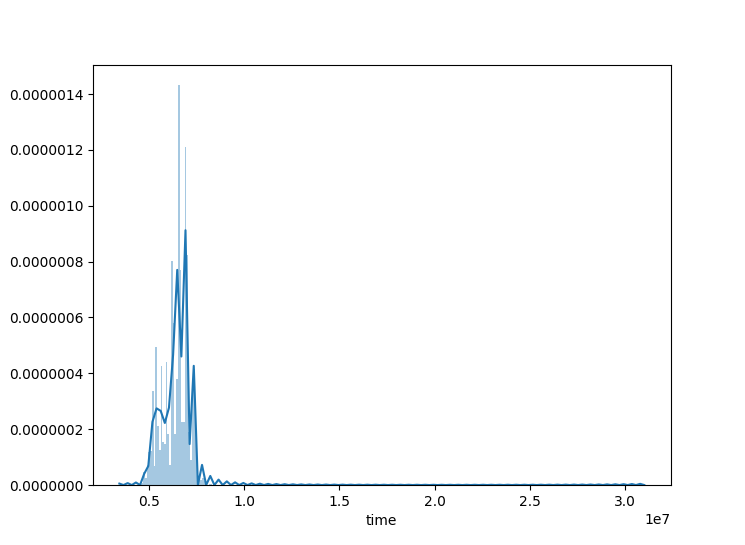

In [11]:
g_samples = pandas.concat([samples_7_1, samples_2800_1, samples_7_400, samples_20_800])['time']
seaborn.distplot(g_samples, bins=300)

## References
  - [1] Remote Timing Attacks are Practical (https://crypto.stanford.edu/~dabo/papers/ssl-timing.pdf)
  - [2] Remote Timing Attacks are Practical, Computer Networks 48 (https://tlseminar.github.io/docs/remotetiming.pdf)
  - [3] Opportunities and Limits of Remote Timing Attacks (https://www.cs.rice.edu/~dwallach/pub/crosby-timing2009.pdf)